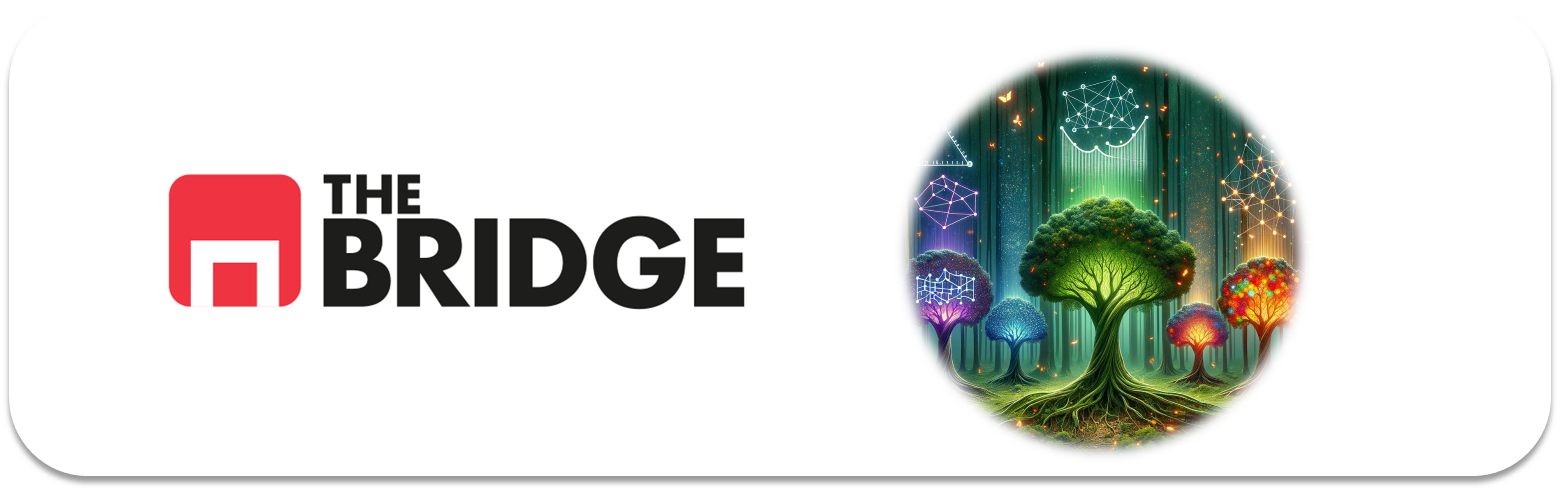

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [170]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [171]:
# En primer lugar vamos a importar la información del dataset
df = pd.read_csv('./data/bank-full.csv', sep=';')

# Comprobamos la tipología de los datos
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [172]:
# LIMPIEZA:
# Vamos a comprobar si existen nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [173]:
# Podemos comprobar que no existen valores nulos por lo que no necesitamos completar o eliminar valores 
# pero sí tendremos que aplicar un OneHotEncoder a las categóricas
# Lo hacemos aquí
# Dichas variables son:
columnas = ['job','marital','education','default','housing','loan','contact','month','poutcome']

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
for col in columnas:
    data = encoder.fit_transform(df[col].values.reshape(-1, 1)).toarray()
    df = pd.concat([
    df.drop(col, axis = 1),
    pd.DataFrame(data, columns = encoder.categories_[0])
    ], axis = 1)


In [174]:
# Comprobamos como queda
df.head()

,age,balance,day,duration,campaign,pdays,previous,y,admin.,blue-collar,...,jun,mar,may,nov,oct,sep,failure,other,success,unknown
0,58,2143,5,261,1,-1,0,no,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44,29,5,151,1,-1,0,no,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33,2,5,76,1,-1,0,no,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47,1506,5,92,1,-1,0,no,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33,1,5,198,1,-1,0,no,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [175]:
# SELECCION DEL TARGET
# De la información obtenida escogemos el target 'y' ya que puede comprobarse que los demás datos tienen que ver con 
# la situación económica del entrevistado o bien datos sobre su ultima entrevista o campaña.
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            45211 non-null  int64  
 1   balance        45211 non-null  int64  
 2   day            45211 non-null  int64  
 3   duration       45211 non-null  int64  
 4   campaign       45211 non-null  int64  
 5   pdays          45211 non-null  int64  
 6   previous       45211 non-null  int64  
 7   y              45211 non-null  object 
 8   admin.         45211 non-null  float64
 9   blue-collar    45211 non-null  float64
 10  entrepreneur   45211 non-null  float64
 11  housemaid      45211 non-null  float64
 12  management     45211 non-null  float64
 13  retired        45211 non-null  float64
 14  self-employed  45211 non-null  float64
 15  services       45211 non-null  float64
 16  student        45211 non-null  float64
 17  technician     45211 non-null  float64
 18  unempl

In [183]:
# SPLIT
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(df,test_size=0.2,random_state=42)

# Generamos los conjuntos necesarios
X_train = train.drop(columns=['y'])
y_train = train['y']

# Cambiamos yes y no por 1 y 0
condicion_si = y_train=='yes'
y_train[condicion_si]=1
condicion_no = y_train=='no'
y_train[condicion_no]=0
y_train = y_train.astype(int)

X_test = test.drop(columns=['y'])
y_test = test['y']

# Cambiamos yes y no por 1 y 0
condicion_si = y_test=='yes'
y_test[condicion_si]=1
condicion_no = y_test=='no'
y_test[condicion_no]=0
y_test = y_test.astype(int)


C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_10676\3997348793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[condicion_si]=1
C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_10676\3997348793.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[condicion_no]=0
C:\Users\juanmanu.gomez\AppData\Local\Temp\ipykernel_10676\3997348793.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test[condicion_si]=1

In [184]:
# MINIEDA
# Comprobamos la distribución del target
X_train.describe()

,age,balance,day,duration,campaign,pdays,previous,admin.,blue-collar,entrepreneur,...,jun,mar,may,nov,oct,sep,failure,other,success,unknown
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,...,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,40.930823,1361.046146,15.817739,256.891202,2.765649,40.180076,0.580264,0.114383,0.215826,0.032570,...,0.119387,0.010341,0.303113,0.087729,0.016562,0.012829,0.107858,0.041390,0.033455,0.817297
std,10.618369,3023.083187,8.325860,256.884103,3.120193,100.107617,2.370668,0.318280,0.411400,0.177511,...,0.324248,0.101163,0.459610,0.282905,0.127624,0.112538,0.310205,0.199194,0.179824,0.386428
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,70.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,39.000000,447.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,48.000000,1429.000000,21.000000,318.000000,3.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


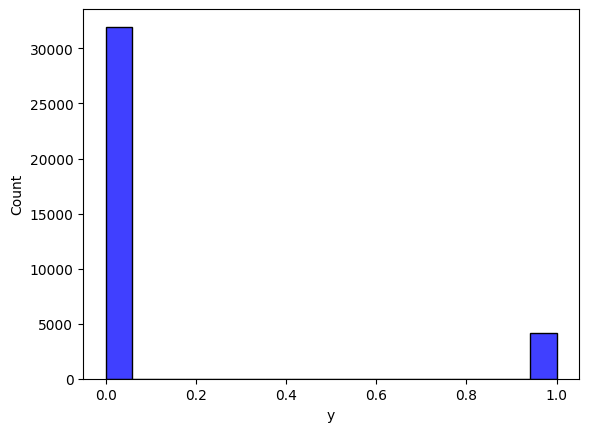

In [185]:
sns.histplot(y_train,color='blue')
plt.show()

In [186]:
# Vamos a intentar hacer un modelo inicial
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=5, # Ponemos una profundidad máxima en 5 dada la cantidad de columnas que tenemos
                                  random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

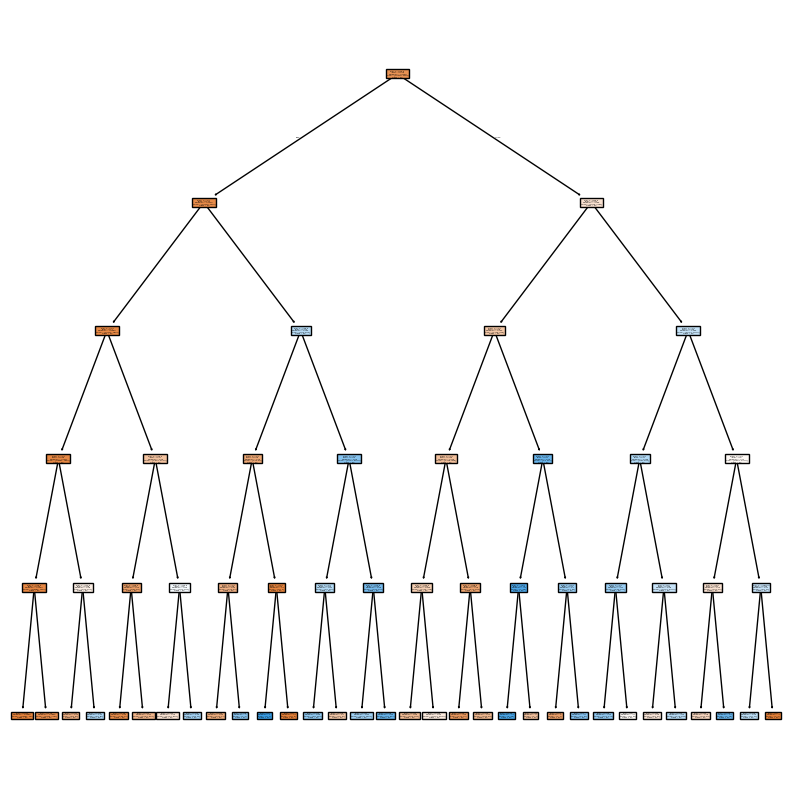

In [187]:
# Pintaremos el arbol
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_clf,
               class_names=df.y,
               filled = True); 

In [189]:
from sklearn.metrics import mean_squared_error
print(tree_clf.score(X_train,y_train))
print(tree_clf.score(X_test, y_test))
print("RMSE", mean_squared_error(y_train, tree_clf.predict(X_train), squared = False))
print("RMSE", mean_squared_error(y_test, tree_clf.predict(X_test), squared = False))


0.9065748728157488
0.8972686055512551
RMSE 0.3056552423634368
RMSE 0.3205173855639424


c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [190]:
# No parece que lo esté haciendo mal pero vamos a intentar optimizarlo.
# Dado que tenemos demasiadas columnas y el arbol tiene muchas ramas y hojas
# vamos a intentar optimizar con un ElasticNet que minimizará el numero de busquedas

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet

param_grid = {
    'alpha': [0, 40],
    'l1_ratio': np.arange(0,1,0.25)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=6, # Nº de iteraciones del random search
                                   cv=3, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(X_train, y_train)


c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+03, tolerance: 3.711e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted

RandomizedSearchCV(cv=3, estimator=ElasticNet(), n_iter=6, n_jobs=-1,
                   param_distributions={'alpha': [0, 40],
                                        'l1_ratio': array([0.  , 0.25, 0.5 , 0.75])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [191]:
random_search.best_params_

{'l1_ratio': 0.5, 'alpha': 0}

In [192]:
random_search.best_estimator_.score(X_test, y_test)

0.30959758965795126

In [196]:
# Hemos conseguido mejorar el valor del error.
# Vamos a intentar mejorar tambien el modelo incrementando la profundidad.

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=10, # Ponemos una profundidad máxima en 5 dada la cantidad de columnas que tenemos
                                  random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

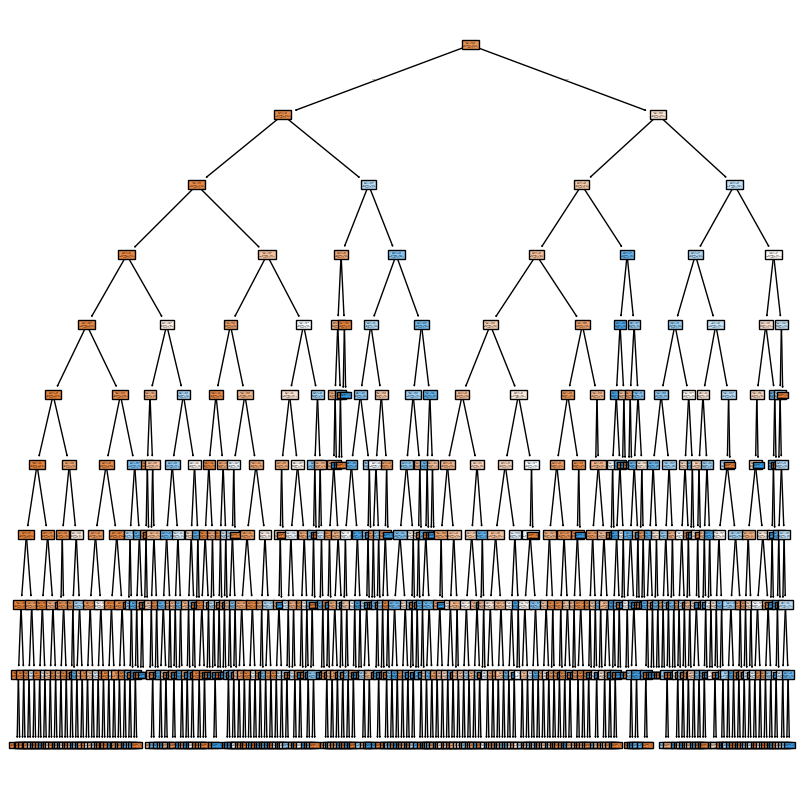

In [194]:
# Pintaremos el nuevo arbol
from sklearn.tree import plot_tree

plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_clf,
               class_names=df.y,
               filled = True); 

In [197]:
from sklearn.metrics import mean_squared_error
print(tree_clf.score(X_train,y_train))
print(tree_clf.score(X_test, y_test))
print("RMSE", mean_squared_error(y_train, tree_clf.predict(X_train), squared = False))
print("RMSE", mean_squared_error(y_test, tree_clf.predict(X_test), squared = False))

0.9257354567573546
0.894061705186332
RMSE 0.2725152165341331
RMSE 0.3254816351403993


c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Vemos que la mejora no es mayor. Se reduce el error en el Train pero se incrementa en el Test, por lo que lo unico que 
# hemos conseguido es sobreajustar al conjunto de entrenamiento por lo que no es una buena estrategia en este caso.
# Podriamos intentar mejorar el valor del error incrementando los valores sobre los que iterar en el ElasticNet. 
# Vamos a hacerlo para ver el resultado.

In [201]:
param_grid = {
    'alpha': [0.01,0,10,40,100],
    'l1_ratio': np.arange(0,1,0.02)
}

elastic = ElasticNet()

random_search2 = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=15, # Nº de iteraciones del random search
                                   cv=3, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search2.fit(X_train, y_train)

c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\juanmanu.gomez\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+03, tolerance: 3.711e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted

RandomizedSearchCV(cv=3, estimator=ElasticNet(), n_iter=15, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0, 10, 40, 100],
                                        'l1_ratio': array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98])},
                   random_state=1, scoring='neg_root_mean_squared_error')

In [202]:
random_search2.best_params_

{'l1_ratio': 0.34, 'alpha': 0}

In [203]:
random_search2.best_estimator_.score(X_test, y_test)

0.30959758965795126

In [ ]:
# La mejora obtenida no es mayor que la obtenida anteriormente a pesar del incremento de parámetros. Podria ser que en una
# busqueda más amplia fuese menor pero de momento vamos a conformarnos con este.